# Forecasting Sales for 45 Walmart Locations

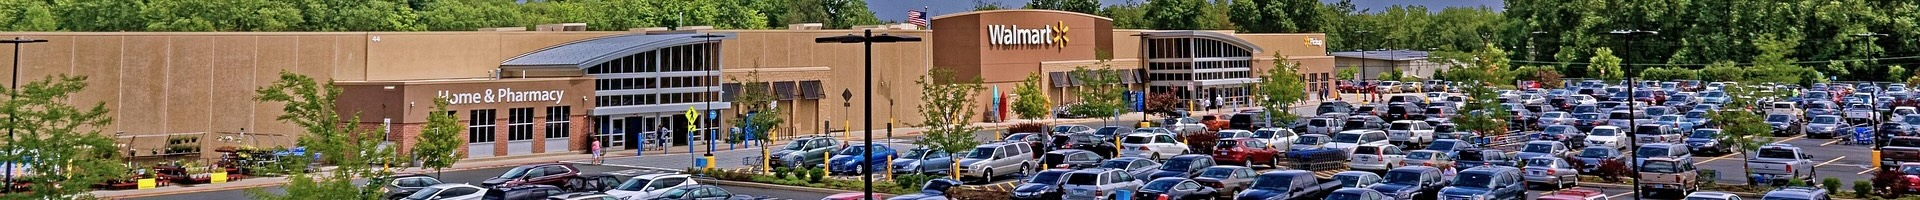
Image by <a href="https://pixabay.com/users/jimarojfm-8012735/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=4054031">jimaro morales</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=4054031">Pixabay</a>

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect & Clean Data](#collect)
* [<span style="color:#A690A4"> 3. Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 4. Forecast Sales](#predict)
* [<span style="color:#A690A4"> 5. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

# <span style="color:#5E6997">Collect & Clean Data</span> <a class="anchor" id="collect"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Define file paths
# features_path = "/kaggle/input/walmart-sales-forecast/features.csv"
# stores_path   = "/kaggle/input/walmart-sales-forecast/stores.csv"
# train_path    = "/kaggle/input/walmart-sales-forecast/train.csv"
# test_path     = "/kaggle/input/walmart-sales-forecast/test.csv"

features_path = "./data/features.csv"
stores_path   = "./data/stores.csv"
train_path    = "./data/train.csv"
test_path     = "./data/test.csv"

# Load datasets
features = pd.read_csv(features_path)
stores   = pd.read_csv(stores_path)
train    = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [3]:
# Convert the 'Date' column to datetime format
features["Date"] = pd.to_datetime(features["Date"], format="%Y-%m-%d")
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

In [4]:
# Get min and max dates for train
train_min = train['Date'].min()
train_max = train['Date'].max()

# Get min and max dates for test
test_min = test['Date'].min()
test_max = test['Date'].max()

# Print the date range for the train dataset with day of the week
print("Train Date Range:")
print("Min Date:", train_min, "-", train_min.day_name())
print("Max Date:", train_max, "-", train_max.day_name())

# Print the date range for the test dataset with day of the week
print("\nTest Date Range:")
print("Min Date:", test_min, "-", test_min.day_name())
print("Max Date:", test_max, "-", test_max.day_name())

Train Date Range:
Min Date: 2010-02-05 00:00:00 - Friday
Max Date: 2012-10-26 00:00:00 - Friday

Test Date Range:
Min Date: 2012-11-02 00:00:00 - Friday
Max Date: 2013-07-26 00:00:00 - Friday


### Walmart Store Data

In [5]:
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
def display_feature_range(df):
    """
    Display the range of values for each column in a DataFrame.
    For numeric (non-boolean) columns, prints the minimum, maximum, and range.
    For non-numeric or boolean columns, prints the unique values.
    """
    for col in df.columns:
        print("=" * 40)
        print(f"Feature: {col}")
        
        # Check for numeric columns excluding booleans
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            print(f"Min: {col_min}")
            print(f"Max: {col_max}")
            print(f"Range: {col_max - col_min}")
        else:
            unique_vals = df[col].unique()
            print("Unique values:", unique_vals)
        print("=" * 40, "\n")

In [8]:
# Call the function with the stores dataset
display_feature_range(stores)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Type
Unique values: ['A' 'B' 'C']

Feature: Size
Min: 34875
Max: 219622
Range: 184747



### Features Data

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [13]:
# Define the list of MarkDown columns
markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

# Fill missing values in the MarkDown columns with 0
features[markdown_cols] = features[markdown_cols].fillna(0)

# Display info to verify that missing values have been filled
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [14]:
# Create boolean masks where True indicates a missing value
mask_cpi = features['CPI'].isna()
mask_unemployment = features['Unemployment'].isna()

# Check if both masks are exactly the same
if mask_cpi.equals(mask_unemployment):
    print("CPI and Unemployment have the exact same missing value pattern.")
else:
    print("CPI and Unemployment have different missing value patterns.")

CPI and Unemployment have the exact same missing value pattern.


In [15]:
# Rows where CPI  is missing
missing_mask = features['CPI'].isna() 
missing_rows = features[missing_mask]
print(missing_rows)

      Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169       1 2013-05-03        66.66       3.386    2298.63       2.00   
170       1 2013-05-10        63.90       3.392    4624.61      83.88   
171       1 2013-05-17        69.53       3.454   16170.50      92.00   
172       1 2013-05-24        77.19       3.494    7959.89     178.00   
173       1 2013-05-31        78.02       3.466    2369.77     142.45   
...     ...        ...          ...         ...        ...        ...   
8185     45 2013-06-28        76.05       3.639    4842.29     975.03   
8186     45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           

In [16]:
# Focus on Store 1 (or whichever store is plotted)
store1 = features[features['Store'] == 1].copy()
store1 = store1.sort_values('Date')

# Inspect data for the time frame around the suspicious jump
suspicious_range = store1[(store1['Date'] >= "2013-04-01") & (store1['Date'] <= "2013-08-31")]
print(suspicious_range[['Date', 'CPI']])

          Date        CPI
165 2013-04-05  225.08654
166 2013-04-12  225.17016
167 2013-04-19  225.17016
168 2013-04-26  225.17016
169 2013-05-03        NaN
170 2013-05-10        NaN
171 2013-05-17        NaN
172 2013-05-24        NaN
173 2013-05-31        NaN
174 2013-06-07        NaN
175 2013-06-14        NaN
176 2013-06-21        NaN
177 2013-06-28        NaN
178 2013-07-05        NaN
179 2013-07-12        NaN
180 2013-07-19        NaN
181 2013-07-26        NaN


In [17]:
print(features[['Date', 'Store', 'CPI', 'Unemployment']].tail(30))

           Date  Store         CPI  Unemployment
8160 2013-01-04     45  192.659622         8.625
8161 2013-01-11     45  192.759980         8.625
8162 2013-01-18     45  192.809507         8.625
8163 2013-01-25     45  192.838701         8.625
8164 2013-02-01     45  192.867895         8.625
8165 2013-02-08     45  192.897089         8.625
8166 2013-02-15     45  192.943471         8.625
8167 2013-02-22     45  193.032822         8.625
8168 2013-03-01     45  193.122173         8.625
8169 2013-03-08     45  193.211524         8.625
8170 2013-03-15     45  193.296277         8.625
8171 2013-03-22     45  193.369533         8.625
8172 2013-03-29     45  193.442790         8.625
8173 2013-04-05     45  193.516047         8.335
8174 2013-04-12     45  193.589304         8.335
8175 2013-04-19     45  193.589304         8.335
8176 2013-04-26     45  193.589304         8.335
8177 2013-05-03     45         NaN           NaN
8178 2013-05-10     45         NaN           NaN
8179 2013-05-17     

In [18]:
# Set Date as the index for interpolation
features.set_index("Date", inplace=True)

# Step 1: Apply Forward-Fill and Backward-Fill at the Global Level
features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill().bfill()

# Step 2: Apply Linear Interpolation Per Store
features = (
    features.groupby("Store", group_keys=False)  # Ensure per-store interpolation
            .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))  
)

# Reset index so Date becomes a column again
features.reset_index(inplace=True)

/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/745865233.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))


In [19]:
print(features[['Date', 'CPI', 'Unemployment']].tail(30))

           Date         CPI  Unemployment
8160 2013-01-04  192.659622         8.625
8161 2013-01-11  192.759980         8.625
8162 2013-01-18  192.809507         8.625
8163 2013-01-25  192.838701         8.625
8164 2013-02-01  192.867895         8.625
8165 2013-02-08  192.897089         8.625
8166 2013-02-15  192.943471         8.625
8167 2013-02-22  193.032822         8.625
8168 2013-03-01  193.122173         8.625
8169 2013-03-08  193.211524         8.625
8170 2013-03-15  193.296277         8.625
8171 2013-03-22  193.369533         8.625
8172 2013-03-29  193.442790         8.625
8173 2013-04-05  193.516047         8.335
8174 2013-04-12  193.589304         8.335
8175 2013-04-19  193.589304         8.335
8176 2013-04-26  193.589304         8.335
8177 2013-05-03  193.589304         8.335
8178 2013-05-10  193.589304         8.335
8179 2013-05-17  193.589304         8.335
8180 2013-05-24  193.589304         8.335
8181 2013-05-31  193.589304         8.335
8182 2013-06-07  193.589304       

/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/293731230.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())


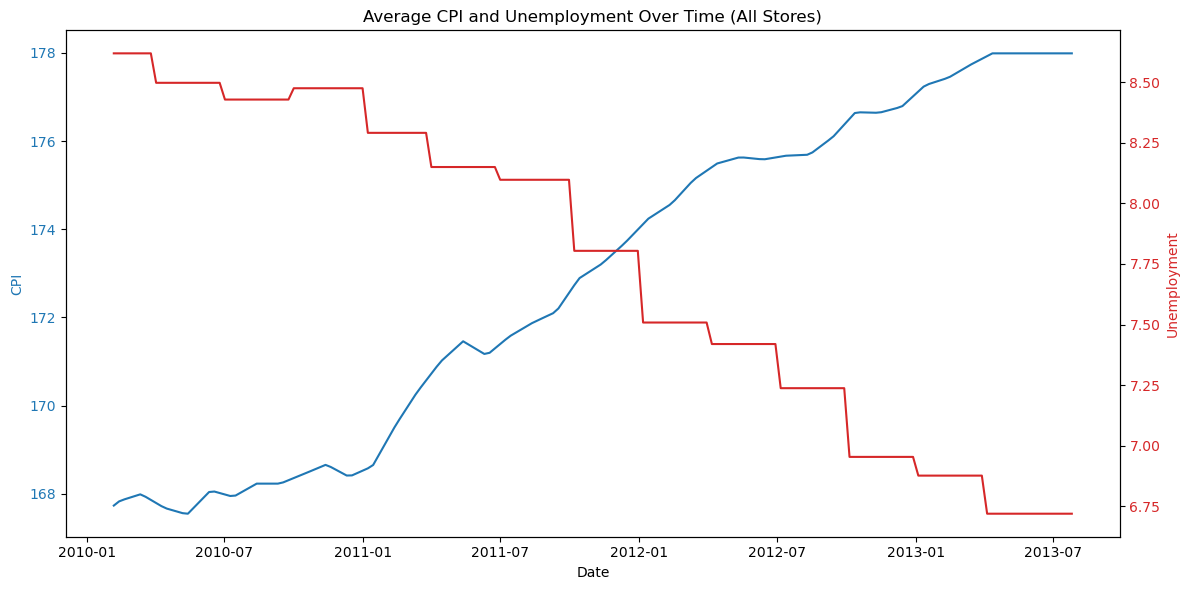

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Date is in datetime format
features['Date'] = pd.to_datetime(features['Date'])

# 2. Sort by Store and Date (only needed once)
features.sort_values(["Store", "Date"], inplace=True)

# 3. Apply Linear Interpolation Per Store (Fix: Use "Date" as the index)
features = (
    features.groupby("Store", group_keys=False)  # Group by store
            .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())  
)

# 4. Aggregate to get daily averages across all stores (ensuring one row per date)
daily_avg = features.groupby('Date', as_index=False).agg({
    'CPI': 'mean',
    'Unemployment': 'mean'
})
daily_avg.sort_values('Date', inplace=True)

# 5. Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# CPI on primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(daily_avg['Date'], daily_avg['CPI'], color=color_cpi, label='Avg CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Unemployment on secondary y-axis
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(daily_avg['Date'], daily_avg['Unemployment'], color=color_unemp, label='Avg Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title("Average CPI and Unemployment Over Time (All Stores)")
fig.tight_layout()
plt.savefig("CPI_Unemployment_all_stores.jpg", format="jpg", dpi=300)
plt.show()


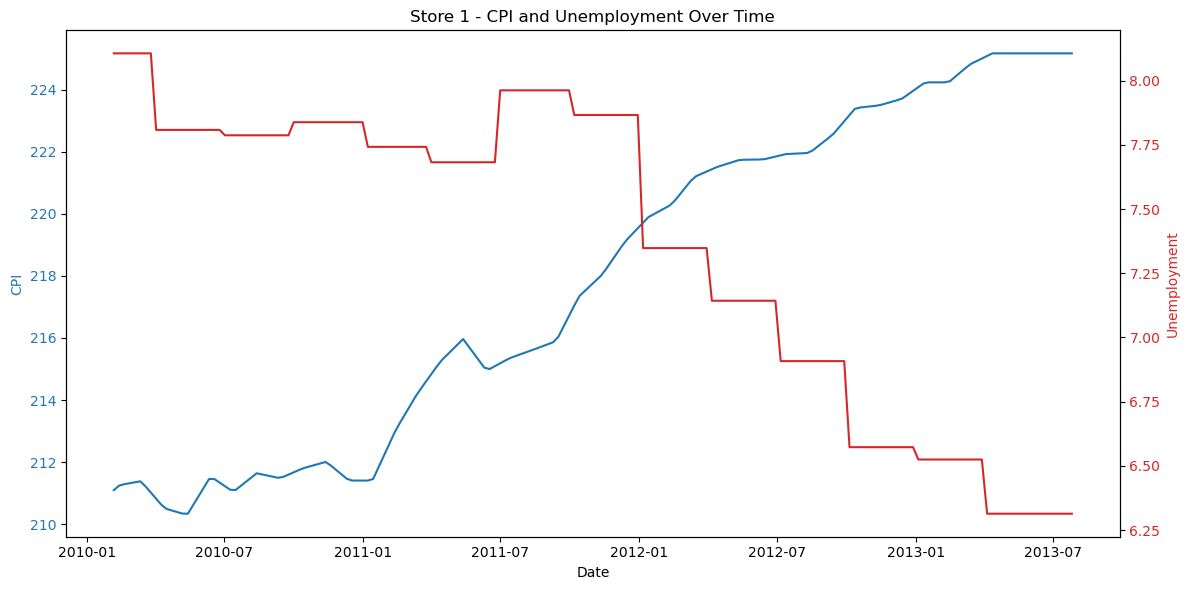

In [21]:

# Assuming 'features' is your DataFrame with interpolated CPI and Unemployment

# Choose the store you want to visualize (e.g., Store 1)
store_id = 1
store_df = features[features['Store'] == store_id].copy()

# Sort by Date to ensure the time series is in order
store_df.sort_values('Date', inplace=True)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot CPI on the primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(store_df['Date'], store_df['CPI'], color=color_cpi, label='CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Create a second y-axis for Unemployment
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(store_df['Date'], store_df['Unemployment'], color=color_unemp, label='Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title(f"Store {store_id} - CPI and Unemployment Over Time")
fig.tight_layout()
plt.savefig(f"Store_{store_id}_CPI_Unemployment_store_1.jpg", format="jpg", dpi=300)
plt.show()


In [22]:
# Focus on a time range around the jump
check_range = daily_avg[(daily_avg['Date'] >= "2013-05-01") & (daily_avg['Date'] <= "2013-08-01")]
print(check_range)

          Date        CPI  Unemployment
169 2013-05-03  177.99068      6.719244
170 2013-05-10  177.99068      6.719244
171 2013-05-17  177.99068      6.719244
172 2013-05-24  177.99068      6.719244
173 2013-05-31  177.99068      6.719244
174 2013-06-07  177.99068      6.719244
175 2013-06-14  177.99068      6.719244
176 2013-06-21  177.99068      6.719244
177 2013-06-28  177.99068      6.719244
178 2013-07-05  177.99068      6.719244
179 2013-07-12  177.99068      6.719244
180 2013-07-19  177.99068      6.719244
181 2013-07-26  177.99068      6.719244


In [23]:
print(daily_avg[['CPI', 'Unemployment']].describe())

              CPI  Unemployment
count  182.000000    182.000000
mean   172.855800      7.747708
std      3.689152      0.647174
min    167.546485      6.719244
25%    168.582724      7.237333
50%    173.084948      7.804222
75%    176.086612      8.428578
max    177.990680      8.619311


In [24]:
# Check CPI and Unemployment for a wider range to see available data points
check_surrounding = daily_avg[(daily_avg['Date'] >= "2013-01-01") & (daily_avg['Date'] <= "2013-12-01")]
print(check_surrounding)

          Date         CPI  Unemployment
152 2013-01-04  177.125367      6.876444
153 2013-01-11  177.235667      6.876444
154 2013-01-18  177.295004      6.876444
155 2013-01-25  177.333956      6.876444
156 2013-02-01  177.372908      6.876444
157 2013-02-08  177.411860      6.876444
158 2013-02-15  177.459922      6.876444
159 2013-02-22  177.530760      6.876444
160 2013-03-01  177.601597      6.876444
161 2013-03-08  177.672434      6.876444
162 2013-03-15  177.740876      6.876444
163 2013-03-22  177.803327      6.876444
164 2013-03-29  177.865778      6.876444
165 2013-04-05  177.928229      6.719244
166 2013-04-12  177.990680      6.719244
167 2013-04-19  177.990680      6.719244
168 2013-04-26  177.990680      6.719244
169 2013-05-03  177.990680      6.719244
170 2013-05-10  177.990680      6.719244
171 2013-05-17  177.990680      6.719244
172 2013-05-24  177.990680      6.719244
173 2013-05-31  177.990680      6.719244
174 2013-06-07  177.990680      6.719244
175 2013-06-14  

In [25]:
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').head(20))  # Inspect the first 20 rows
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').tail(20))  # Inspect the last 20 rows

        Date         CPI  Unemployment
0 2010-02-05  211.096358         8.106
0 2010-02-05  189.381697         7.039
0 2010-02-05  210.752605         8.324
0 2010-02-05  210.752605         8.324
0 2010-02-05  131.527903         8.488
0 2010-02-05  189.381697         7.541
0 2010-02-05  131.527903         8.350
0 2010-02-05  189.381697         9.014
0 2010-02-05  212.622352         7.259
0 2010-02-05  204.247194         8.187
0 2010-02-05  214.471451         6.299
0 2010-02-05  181.871190         8.992
0 2010-02-05  126.442065        10.115
0 2010-02-05  131.527903         8.326
0 2010-02-05  131.527903         5.892
0 2010-02-05  209.852966         8.554
0 2010-02-05  135.352461         8.237
0 2010-02-05  131.527903         5.892
0 2010-02-05  135.352461         8.283
0 2010-02-05  214.424881         7.368
          Date         CPI  Unemployment
181 2013-07-26  225.766502         5.278
181 2013-07-26  223.836362         6.143
181 2013-07-26  226.802140         5.285
181 2013-07-26  1

In [26]:
display_feature_range(features)

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2013-05-24 00:00:00', '2013-05-31 00:00:00', '2013-06-07 00:00:00',
 '2013-06-14 00:00:00', '2013-06-21 00:00:00', '2013-06-28 00:00:00',
 '2013-07-05 00:00:00', '2013-07-12 00:00:00', '2013-07-19 00:00:00',
 '2013-07-26 00:00:00']
Length: 182, dtype: datetime64[ns]

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Temperature
Min: -7.29
Max: 101.95
Range: 109.24000000000001

Feature: Fuel_Price
Min: 2.472
Max: 4.468
Range: 1.996

Feature: MarkDown1
Min: -2781.45
Max: 103184.98
Range: 105966.43

Feature: MarkDown2
Min: -265.76
Max: 104519.54
Range: 104785.29999999999

Feature: MarkDown3
Min: -179.26
Max: 149483.31
Range: 149662.57

Feature: MarkDown4
Min: 0.0
Max: 67474.85
Range: 67474.85

Feature: MarkD

### Train/Test Data

In [27]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [28]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


In [31]:
display_feature_range(train)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Dept
Min: 1
Max: 99
Range: 98

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2012-08-24 00:00:00', '2012-08-31 00:00:00', '2012-09-07 00:00:00',
 '2012-09-14 00:00:00', '2012-09-21 00:00:00', '2012-09-28 00:00:00',
 '2012-10-05 00:00:00', '2012-10-12 00:00:00', '2012-10-19 00:00:00',
 '2012-10-26 00:00:00']
Length: 143, dtype: datetime64[ns]

Feature: Weekly_Sales
Min: -4988.94
Max: 693099.36
Range: 698088.2999999999

Feature: IsHoliday
Unique values: [False  True]



# <span style="color:#5E6997">Wrangle & Explore Data</span> <a class="anchor" id="process"></a>

In [32]:
# Merge the 'store' information into 'features'
train = train.merge(stores, on="Store", how="left")

In [33]:
# Merge 'train' with 'features' on Store and Date
train = train.merge(features, on=["Store", "Date"], how="left")

Calculate Sales per Sqaure Foot.

In [34]:
train_efficiency = train.groupby('Store', as_index=False)['Weekly_Sales'].sum()
train_efficiency = train_efficiency.merge(stores[['Store', 'Size']], on='Store')
train['Sales_per_sqft'] = train_efficiency['Weekly_Sales'] / train_efficiency['Size']


In [35]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y',
       'Sales_per_sqft'],
      dtype='object')

In [37]:
# Rename 'IsHoliday_y' to 'Holiday'
train.rename(columns={'IsHoliday_y': 'Holiday'}, inplace=True)

# Drop 'IsHoliday_x' 
train.drop(columns=['IsHoliday_x'], inplace=True, errors='ignore')

In [38]:
train.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday,Sales_per_sqft
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1469.800144
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,1361.210640
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,1540.081704
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,1455.064550
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,1303.962406


### Sales Trends Over Time

Goal: Identify seasonal trends, holiday effects, and overall sales growth.

In [39]:

# # Aggregate total weekly sales per Date
# weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# # Plot total sales over time
# plt.figure(figsize=(12,6))
# plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Total Weekly Sales', color='tab:blue', alpha=0.7)
# plt.xlabel("Date")
# plt.ylabel("Total Weekly Sales")
# plt.title("Walmart Weekly Sales Trend Over Time")
# plt.legend()
# plt.grid(True)
# plt.savefig("Sales_Trends_Over_Time.jpg", format="jpg", dpi=300)
# plt.show()


Graph observations:

1. **Seasonal Peaks** – There are **sharp spikes** in sales, particularly around the **end of each year**. This suggests that major shopping events, such as **Black Friday and holiday sales**, significantly impact sales figures.
2. **General Fluctuations** – While sales remain relatively stable throughout the time period, **there are noticeable fluctuations** that might correspond to promotional periods, economic conditions, or external factors affecting consumer spending.
3. **Downward Trends** – The beginning of the dataset (2010) shows relatively **higher variance**, with some downward trends visible over time. This could indicate changes in store performance, economic conditions, or shifts in consumer behavior.
4. **Post-Holiday Declines** – After each peak, sales **drop sharply**, suggesting that consumers **spend significantly more during peak shopping seasons** and cut back afterward.

### Total Sales by Store

Goal: Find which stores generate the most revenue and spot outliers.

In [40]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Step 1: Aggregate total sales per store
# store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values().reset_index()

# # Step 2: Merge with store metadata to get 'Type'
# store_metadata = stores[['Store', 'Type']]  # assuming your store info is in a DataFrame called 'stores'
# store_sales = store_sales.merge(store_metadata, on='Store')

# # Step 3: Assign colors to each type
# type_colors = {'A': 'skyblue', 'B': 'orange', 'C': 'green'}
# store_sales['Color'] = store_sales['Type'].map(type_colors)

# # Step 4: Plot
# plt.figure(figsize=(12,6))
# plt.bar(store_sales['Store'].astype(str), store_sales['Weekly_Sales'], color=store_sales['Color'], alpha=0.8)

# # Step 5: Formatting
# plt.xlabel("Store Number")
# plt.ylabel("Total Sales")
# plt.title("Total Sales by Store (Color-Coded by Store Type)")
# plt.xticks(rotation=90)
# plt.grid(axis='y')

# # Step 6: Custom Legend
# handles = [plt.Rectangle((0,0),1,1, color=col) for col in type_colors.values()]
# labels = [f"Type {t}" for t in type_colors.keys()]
# plt.legend(handles, labels, title="Store Type")

# # Step 7: Save and Show
# plt.tight_layout()
# plt.savefig("Sales_By_Store_Type_Overlay.jpg", format="jpg", dpi=300)
# plt.show()

1. **Wide Range of Sales Performance**  
   - There is a **significant disparity** in total sales between stores.  
   - The lowest-performing stores have total sales below **$50,000,000**, whereas the highest-performing stores exceed **$300,000,000**.

2. **Top-Performing Stores**  
   - The rightmost bars represent **high-revenue stores**, with Store **20, 14, 4, 13, and 2** among the top earners.  
   - These stores have total sales ranging from approximately **$250,000,000 to $310,000,000**.

3. **Lowest-Performing Stores**  
   - The leftmost bars (e.g., Stores **33, 44, 5**) indicate locations with **substantially lower sales**, potentially due to **smaller customer bases, lower foot traffic, or regional economic factors**.  
   - These stores have total sales well under **$50,000,000**, with the lowest ones close to **$40,000,000**.

4. **Smooth Gradient in Sales**  
   - The **Blues colormap** visually emphasizes the progression from **low to high sales**, making it clear that **certain stores contribute disproportionately to total revenue**.  
   - There is a **steady increase in sales**, suggesting that sales performance is not random but influenced by specific factors like **location, demographics, and store size**.

5. **Possible Business Implications**  
   - **Investigate what makes the top stores successful** (e.g., location, promotions, store size, inventory variety).  
   - **Identify challenges in lower-performing stores** (e.g., competition, demographics, operational inefficiencies).  
   - **Optimize store allocation, marketing, or inventory** based on regional performance to improve sales for underperforming stores.

**Potential Next Steps**
- **Compare rankings with store size and foot traffic data** to determine **store efficiency**.  
- **Analyze seasonality in sales** across top vs. bottom-performing stores to detect **patterns in consumer behavior**.  
- **Evaluate external factors** like **CPI, Unemployment, or regional economic indicators** to see how they correlate with store performance and adjust strategies accordingly.  

### Total Sales and Sales per Sq Ft by Store

In [41]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# # Step 1: Aggregate data
# store_summary = (
#     train.groupby("Store", as_index=False)
#          .agg({
#              "Weekly_Sales": "sum",
#              "Size": "first",
#              "Type": "first"
#          })
# )
# store_summary["Sales_per_sqft"] = store_summary["Weekly_Sales"] / store_summary["Size"]

# # Step 2: Sort by sales per square foot and set categorical order for plotting
# store_summary.sort_values("Sales_per_sqft", inplace=True)
# store_summary["Store"] = store_summary["Store"].astype(str)
# store_summary["Store"] = pd.Categorical(store_summary["Store"], categories=store_summary["Store"], ordered=True)

# # Step 3: Color mapping by Type
# type_colors = {'A': 'skyblue', 'B': 'orange', 'C': 'green'}
# store_summary["Color"] = store_summary["Type"].map(type_colors)

# # Step 4: Plotting
# fig, ax1 = plt.subplots(figsize=(14,6))

# # Bar plot: Total Sales
# bars = ax1.bar(
#     store_summary["Store"], 
#     store_summary["Weekly_Sales"], 
#     color=store_summary["Color"], 
#     alpha=0.7,
#     label="Total Sales"
# )
# ax1.set_ylabel("Total Sales ($)", color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # Line plot: Sales per Square Foot
# ax2 = ax1.twinx()
# ax2.plot(
#     store_summary["Store"], 
#     store_summary["Sales_per_sqft"], 
#     color='tab:red', 
#     marker='o', 
#     linewidth=2,
#     label="Sales per Sq Ft"
# )
# ax2.set_ylabel("Sales per Sq Ft ($)", color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')

# # Titles and formatting
# plt.title("Total Sales and Sales per Sq Ft by Store (Sorted by Efficiency)")
# ax1.set_xlabel("Store Number (Ordered by Sales per Sq Ft)")
# plt.xticks(rotation=90)
# ax1.grid(axis='y', linestyle='--', alpha=0.5)

# # Custom legend
# legend_elements = [
#     plt.Line2D([0], [0], color='tab:red', lw=2, label='Sales per Sq Ft'),
#     plt.Rectangle((0,0),1,1, color='skyblue', label='Type A'),
#     plt.Rectangle((0,0),1,1, color='orange', label='Type B'),
#     plt.Rectangle((0,0),1,1, color='green', label='Type C')
# ]
# ax1.legend(handles=legend_elements, title="Legend", loc='upper left')

# # Save and show
# plt.tight_layout()
# plt.savefig("Sales_and_Efficiency_by_Store.jpg", format="jpg", dpi=300)
# plt.show()


### Impact of CPI and Markdowns on Sales

Goal: Understand if economic conditions affect Walmart sales.


In [42]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Step 1: Aggregate CPI per Date
# cpi_avg = features.groupby('Date', as_index=False)['CPI'].mean()

# # Step 2: Aggregate total Weekly Sales per Date
# weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# # Step 3: Create a flag for markdown activity
# markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
# train['Any_Markdown'] = train[markdown_cols].fillna(0).sum(axis=1) > 0
# markdown_flags = train.groupby('Date', as_index=False)['Any_Markdown'].any()

# # Step 4: Merge into one DataFrame
# cpi_sales = (
#     cpi_avg
#     .merge(weekly_sales, on='Date')
#     .merge(markdown_flags, on='Date')
# )

# # Step 5: Plot with correct colors
# plt.figure(figsize=(12,6))

# # Use fixed color values
# plt.scatter(
#     cpi_sales[cpi_sales['Any_Markdown'] == True]['CPI'],
#     cpi_sales[cpi_sales['Any_Markdown'] == True]['Weekly_Sales'],
#     color='tab:orange', label='Markdown Active', alpha=0.6
# )

# plt.scatter(
#     cpi_sales[cpi_sales['Any_Markdown'] == False]['CPI'],
#     cpi_sales[cpi_sales['Any_Markdown'] == False]['Weekly_Sales'],
#     color='tab:green', label='No Markdown', alpha=0.6
# )

# # Plot formatting
# plt.xlabel("Consumer Price Index (CPI)")
# plt.ylabel("Total Weekly Sales")
# plt.title("Relationship Between CPI and Sales (Color-Coded by Markdown Activity)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Sales_vs_CPI_Markdown_Color.jpg", format="jpg", dpi=300)
# plt.show()


 **Observations:**

1. **Two Color Groups:**
   - **🟠 Orange = Markdown Active**: These dates had at least one markdown event (MarkDown1–5 > 0).
   - **🟢 Green = No Markdown**: These dates had no markdowns.

2. **Sales Distribution:**
   - **Markdown Events (Orange)** are generally associated with **higher variance in sales**, including several of the **highest peaks** in weekly sales.
   - **No Markdown Dates (Green)** show more **clustering around the lower-to-mid sales range**, particularly between **$4M and $5M** per week.

3. **CPI Clustering:**
   - Most data points are grouped around **CPI values between 167 and 177**.
   - Markdown events seem to occur more frequently at **higher CPI levels (around 174–177)**.

4. **High Sales Outliers:**
   - A few outliers with **very high sales (above $7M–$8M)** are associated with **markdown periods**, suggesting markdowns may have helped drive exceptional sales performance on some dates.

---

**Key Insights:**

- Markdown campaigns **may have a positive influence on boosting sales**, especially under **inflationary conditions** (higher CPI).
- However, not all markdown periods lead to higher sales — there are markdown-active dates with **sales within the regular range**, suggesting **other factors (seasonality, holidays, promotions)** may also be influencing results.
- There is **no strong linear relationship** between CPI and total sales, but markdown activity clearly **modulates the relationship**.

---

**Recommendations:**

- Consider analyzing **seasonal timing** of markdowns to confirm if high sales are holiday-driven.
- Run a regression model or correlation test to quantify markdown effectiveness across different CPI bands.
- Explore combining this with **Unemployment** or **Fuel Price** to create a **multi-factor impact dashboard**.

### Impact of Unemployment on Sales

In [43]:

# # Aggregate Unemployment to match sales data (average Unemployment per Date)
# unemployment_avg = features.groupby('Date', as_index=False)['Unemployment'].mean()

# # Aggregate Weekly Sales to match Unemployment data (sum sales per Date)
# weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# # Merge Unemployment and Sales so both have the same number of rows
# unemp_sales = pd.merge(unemployment_avg, weekly_sales, on='Date')

# # Scatter plot
# plt.figure(figsize=(12,6))
# plt.scatter(unemp_sales['Unemployment'], unemp_sales['Weekly_Sales'], color='tab:red', alpha=0.5)
# plt.xlabel("Unemployment Rate")
# plt.ylabel("Total Weekly Sales")
# plt.title("Relationship Between Unemployment and Sales")
# plt.grid(True)
# plt.savefig(f"Sales_vs_Unemployment.jpg", format="jpg", dpi=300)
# plt.show()

Observations:

1. **No Strong Trend Between Unemployment and Sales**  
   - The points are **widely scattered** with no clear upward or downward pattern.
   - This suggests **no obvious correlation** between unemployment and weekly sales.

2. **Sales Remain Relatively Stable Across Unemployment Levels**  
   - Most sales values cluster between **$40M** and **$50M** across different unemployment rates.
   - A few extreme values (above **$80M**) occur at various unemployment levels, indicating **other factors influencing sales spikes** (e.g., holiday seasons or promotions).

3. **Higher Sales Spikes Around 7.75% and 8.5% Unemployment**  
   - A few **outlier sales points** above **$70M** appear when unemployment is at **7.75% and 8.5%**.
   - This could mean that **seasonal events** or **government stimulus programs** influenced consumer spending at certain unemployment levels.

4. **Potential Business Implications**  
   - If unemployment were a major driver of sales, we might expect lower sales when unemployment is high. However, this graph does not **clearly support that hypothesis**.
   - Walmart’s sales may be **resilient** to unemployment fluctuations due to its position as a discount retailer (people may shop more at Walmart when economic conditions worsen).

### **Next Steps for Further Analysis**
- **Compute the correlation coefficient** to measure the strength of the relationship between unemployment and sales.
- **Overlay a trend line** to check for subtle patterns.
- **Segment data by year or season** to see if the relationship changes during economic downturns or major events.
- **Compare this with the CPI vs. Sales graph** to determine which economic indicator has a stronger impact.

Would you like to add **trend lines or color code the points based on seasons**? 📊

### Sales Comparison: Holiday vs. Non-Holiday Weeks

Goal: Measure the impact of holidays on sales.

In [44]:
# holiday_sales = train.groupby('Holiday')['Weekly_Sales'].sum()
# plt.figure(figsize=(8,6))
# holiday_sales.plot(kind='bar', color=['tab:blue', 'tab:orange'], alpha=0.7)
# plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
# plt.ylabel("Total Sales")
# plt.title("Sales During Holidays vs. Non-Holidays")
# plt.grid(axis='y')
# plt.savefig("Holiday_Sales.jpg", format="jpg", dpi=300)
# plt.show()

Observations:
1. **Sales Are Significantly Higher on Non-Holiday Weeks**  
   - Non-holiday weeks contribute **over $6 billion** in total sales, while holiday weeks contribute **significantly less**.
   - This may seem counterintuitive because holidays often see shopping spikes, but Walmart operates year-round, and **non-holiday weeks outnumber holiday weeks**, leading to higher cumulative sales.

2. **Holiday Sales Are Noticeably Lower in Total**  
   - Despite known shopping surges on holidays like **Black Friday or Christmas**, the total sales from these weeks appear **much lower** compared to non-holiday weeks.
   - This could be due to **fewer holiday weeks overall** rather than lower individual weekly sales.

3. **Potential Explanations for This Trend**  
   - The dataset might define **holidays too narrowly**, possibly including only major U.S. holidays (e.g., Christmas, Thanksgiving, Labor Day) and **excluding other high-sales periods like back-to-school shopping**.
   - Holiday shopping spikes may be offset by **weeks of buildup purchases** leading to sales spread across multiple weeks.

#### **Business Implications:**
- **Adjust Holiday Definitions:**  
  - Reevaluate how holidays are defined in the dataset. Including events like **Black Friday weekends** or **pre-holiday shopping periods** might change the comparison.
  
- **Look at Per-Week Sales Instead of Total Sales:**  
  - Instead of aggregating total sales, a **per-week comparison** might reveal whether holiday weeks have higher sales per week compared to non-holiday weeks.

- **Segment Holidays Individually:**  
  - Break down the analysis by **specific holidays** to see which ones actually drive Walmart’s sales the most.

### Store Performance Over Time (Top 5 & Bottom 5)

Goal: Compare high-performing vs. low-performing stores.

In [45]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# # Get total sales per store
# store_totals = train.groupby("Store")["Weekly_Sales"].sum().sort_values()

# # Select top 5 and bottom 5 stores
# top_stores = store_totals.tail(5)
# bottom_stores = store_totals.head(5)

# # Combine and sort by total sales
# selected_stores = pd.concat([bottom_stores, top_stores])
# sorted_store_ids = selected_stores.index.tolist()

# # Filter and prepare the data
# top_bottom_df = (
#     train[train["Store"].isin(sorted_store_ids)]
#     .groupby(["Date", "Store"], as_index=False)["Weekly_Sales"]
#     .sum()
# )
# top_bottom_df.sort_values("Date", inplace=True)

# # Color mapping (smooth gradient)
# colors = cm.Reds(np.linspace(0, 1, len(sorted_store_ids)))

# # Plot
# plt.figure(figsize=(12,6))
# for i, store in enumerate(sorted_store_ids):
#     subset = top_bottom_df[top_bottom_df["Store"] == store]
#     plt.plot(subset["Date"], subset["Weekly_Sales"], 
#              label=f"Store {store}", color=colors[i])

# # Formatting
# plt.xlabel("Date")
# plt.ylabel("Total Weekly Sales")
# plt.title("Sales Trends for Top & Bottom 5 Stores (Legend Ordered by Total Sales)")
# # Invert legend order
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1], title="Stores (by Total Sales)")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Top_and_Bottom_Stores.jpg", format="jpg", dpi=300)
# plt.show()



1. **Comparison of Top vs. Bottom Stores**:
   - The **top 5 stores** have significantly higher total weekly sales, consistently staying above **\$1.5M** in weekly sales.
   - The **bottom 5 stores** exhibit much lower sales, staying **below \$500K** weekly.
   - The separation in sales between the top and bottom stores is **clearly visible**.

2. **Seasonal Spikes**:
   - There are **sharp spikes in sales** at certain points, likely corresponding to holiday seasons or major sales events (e.g., Black Friday).
   - The **top stores** experience **higher magnitude spikes** compared to the bottom stores.

3. **Sales Stability**:
   - **Top stores** show a more **consistent trend** with fluctuations.
   - **Bottom stores** have a **flatter trend** with very little variation over time.

4. **Use of Line Colors**:
   - The **darker lines represent higher sales stores**, while the **lighter lines represent lower sales stores**.
   - This color contrast effectively differentiates performance levels.

### Sales Trends by Store Type


Why? Store types (A, B, C) likely have different sales patterns. This can help determine which store types are performing better.

In [46]:
# import seaborn as sns
# import warnings

# # Suppress only FutureWarnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# # Group data properly
# train_grouped = train.groupby(['Date', 'Type'], as_index=False)['Weekly_Sales'].sum()

# # Plot sales trends by store type
# plt.figure(figsize=(12,6))
# sns.lineplot(data=train_grouped, x='Date', y='Weekly_Sales', hue='Type')

# # Formatting
# plt.title("Total Weekly Sales Trends by Store Type")
# plt.xlabel("Date")
# plt.ylabel("Total Weekly Sales")
# plt.legend(title="Store Type")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.savefig("Sales_Trend_by_Store_Type.jpg", format="jpg", dpi=300)
# plt.show()


1. **Sales Distribution Across Store Types**:
   - **Type A stores** (blue) generate the highest total weekly sales, significantly outperforming the other store types.
   - **Type B stores** (orange) have moderate sales but still show seasonal peaks.
   - **Type C stores** (green) contribute the least to total weekly sales.

2. **Seasonal Sales Peaks**:
   - There are **noticeable spikes in sales** at certain intervals, likely coinciding with major shopping events (e.g., Black Friday, holiday sales).
   - These spikes are **more pronounced for Type A and B stores**, whereas Type C stores remain relatively stable.

3. **Overall Trend**:
   - **Type A stores show a slight downward trend** over time, indicating either market saturation or external economic factors.
   - **Type B stores maintain relatively steady sales** with minor fluctuations.
   - **Type C stores remain consistently low**, indicating they cater to a smaller customer base.

4. **Legend & Color Usage**:
   - The **legend effectively distinguishes between store types**.
   - The **colors are well-chosen** to differentiate trends without confusion.

### **Potential Enhancements**:
✅ Add **trend lines** to show long-term sales direction.  
✅ Include **annotations** for key sales events to improve insights.  

### Impact of Store Size on Sales

Why? Larger stores may have higher sales, but does size correlate with better performance?

In [47]:
# # Ensure 'Size' is included in the groupby result
# store_sales_size = train.groupby("Store", as_index=False).agg({
#     "Weekly_Sales": "sum",
#     "Size": "first"  # Retain each store's Size value
# })

# # Plot the scatterplot with regression line
# plt.figure(figsize=(12,6))
# sns.scatterplot(data=store_sales_size, x="Size", y="Weekly_Sales", alpha=0.6)
# sns.regplot(data=store_sales_size, x="Size", y="Weekly_Sales", scatter=False, color='red')

# plt.title("Relationship Between Store Size and Total Sales")
# plt.xlabel("Store Size (sq ft)")
# plt.ylabel("Total Sales")
# plt.grid(True)
# plt.savefig("Impact_of_Store_Size_on_Sales.jpg", format="jpg", dpi=300)
# plt.show()

1. **Positive Correlation**:
   - The **scatter plot** shows a clear **positive correlation** between store size and total sales.
   - As the **store size increases**, the **total sales tend to be higher**.

2. **Regression Line**:
   - The **red regression line** suggests a strong **linear relationship**.
   - The **shaded confidence interval** around the regression line indicates a **moderate variance** in the relationship.

3. **Outliers**:
   - Some **large stores** (above ~175,000 sq ft) **do not fit the trend perfectly**, showing variation in sales.
   - Similarly, a few **small stores** (below ~50,000 sq ft) also show slightly higher sales than expected.

4. **Key Takeaways**:
   - **Larger stores tend to generate more total sales**, reinforcing the idea that store size is a major driver of revenue.
   - However, **store size alone is not the only factor**—there are still variations in sales across similar-sized stores.

---

### **Potential Enhancements**:
✅ **Color-code points based on store type** to see if Type A, B, and C stores follow different sales patterns.  
✅ **Annotate outliers** to analyze why they perform better/worse than expected.  
✅ **Use a polynomial regression** to check if the relationship is slightly non-linear.

### Sales vs Fuel Price (for Different Store Types)

In [48]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12,6))

# # Scatterplot with store type as hue
# sns.scatterplot(data=train, x='Fuel_Price', y='Weekly_Sales', hue='Type', alpha=0.5)

# # Formatting
# plt.title("Impact of Fuel Price on Weekly Sales (Color-Coded by Store Type)")
# plt.xlabel("Fuel Price")
# plt.ylabel("Weekly Sales")
# plt.legend(title="Store Type")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Sales_vs_Fuel_Price_by_Type.jpg", format="jpg", dpi=300)
# plt.show()


**Key Observations:**

1. **Store Type A Dominates Sales Volume**
    - Store Type **A** (blue dots) consistently has **much higher weekly sales** than Types B and C.
    - These stores also display the **widest spread** across fuel price levels, suggesting resilience or scale.

2. **Store Types B and C Cluster at Lower Sales**
    - Types **B** (orange) and **C** (green) have **lower weekly sales overall**, rarely exceeding $100,000–150,000 per week.
    - Type C shows a particularly **tight vertical band** at lower sales figures, indicating smaller or less busy locations.

3. **Fuel Price Doesn’t Strongly Impact Sales**
    - Across all store types, **no clear trend** or correlation is visible between fuel price and weekly sales.
    - Sales for all store types appear **relatively stable** even as fuel prices range from ~$2.5 to $4.5 per gallon.
    - This suggests that **fuel prices may not be a strong driver** of weekly sales variation at the store level.

4. **Density Effects & Clustering**
    - There's a **high density of blue dots** (Store A) near $150,000–200,000 weekly sales, regardless of fuel price.
    - Store B and C points show more **banded or flat patterns**, possibly due to narrower product offerings or smaller customer bases.

---

**Summary:**
- **Store type** has a **far greater impact** on weekly sales than fuel price.
- **Fuel price fluctuations** seem to have **minimal influence** on short-term weekly revenue.
- Type A stores appear **more robust** and capable of maintaining sales despite external cost factors like fuel.

### Sales Trends During Markdown Periods

Why? Understanding how markdowns impact sales can be crucial for promotional strategies.

In [49]:
# plt.figure(figsize=(12,6))
# sns.boxplot(data=train.melt(id_vars=['Weekly_Sales'], value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']),
#             x='variable', y='value')
# plt.title("Distribution of Markdown Values")
# plt.xlabel("Markdown Type")
# plt.ylabel("Discount Value")
# plt.grid(True)
# plt.savefig("Markdown_Distribution.jpg", format="jpg", dpi=300)
# plt.show()

1. **Outliers** – There are many high-value outliers across all markdown types, indicating that markdown values can occasionally be very large.
2. **Skewed Distribution** – Most markdown values are concentrated near zero, suggesting that high markdown values are rare.
3. **Variation Among Types** – MarkDown1 and MarkDown5 appear to have more variation in markdown values compared to MarkDown2, MarkDown3, and MarkDown4, which remain close to zero.

### Suggested Improvements:
- **Use a Log Scale:** Since markdown values have extreme outliers, using a logarithmic scale on the y-axis (e.g., `plt.yscale('log')`) can better highlight differences across markdown types.
- **Add a Violin Plot:** A violin plot can help visualize the density of markdown values better than a standard box plot.
- **Color Variation:** Different colors for each markdown type would improve readability.
- **Remove Extreme Outliers:** If extreme values make it difficult to see trends, consider filtering out the highest percentiles (e.g., 99th percentile).

In [50]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Reshape the markdown columns into long format
# melted_md = train.melt(
#     id_vars=['Weekly_Sales'],
#     value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'],
#     var_name='Markdown Type',
#     value_name='Discount Value'
# )

# # Create violin plot
# plt.figure(figsize=(12,6))
# sns.violinplot(data=melted_md, x='Markdown Type', y='Discount Value', inner='box', cut=0)

# # Formatting
# plt.title("Distribution of Markdown Values by Type (Violin Plot)")
# plt.xlabel("Markdown Type")
# plt.ylabel("Discount Value")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Markdown_Distribution_Violin.jpg", format="jpg", dpi=300)
# plt.show()

### Sales in Three Segments (Low, Medium, and High Sales)

In [51]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Create Markdown1 bins (e.g., tertiles or custom bins)
# train['MarkDown1_Binned'] = pd.cut(
#     train['MarkDown1'].fillna(0),  # handle NaNs as 0
#     bins=[-1, 1000, 10000, train['MarkDown1'].max()],
#     labels=['Low', 'Medium', 'High']
# )

# # Plot
# plt.figure(figsize=(12,6))
# sns.scatterplot(
#     data=train, 
#     x='MarkDown1', 
#     y='Weekly_Sales', 
#     hue='MarkDown1_Binned', 
#     alpha=0.5,
#     palette='coolwarm'
# )

# # Labels and formatting
# plt.title("Impact of MarkDown1 on Weekly Sales (Binned by Discount Level)")
# plt.xlabel("MarkDown1 Discount Amount")
# plt.ylabel("Weekly Sales")
# plt.legend(title="Markdown Level")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Markdown1_Impact_on_Sales_Binned.jpg", format="jpg", dpi=300)
# plt.show()


**Key Observations**

1. **Low Markdowns Can Still Lead to High Sales**
- Some of the **highest weekly sales values** (up to ~$700,000) occur even when **MarkDown1 is low** (blue).
- Suggests that **big sales events or holidays** can drive high revenue **regardless of markdown depth**.

2. **Medium Discounts Have a Dense Cluster**
- The **medium markdown band** (gray, roughly $1K–$10K) has a **dense concentration of points** between $50,000 and $200,000 weekly sales.
- This could represent a **“sweet spot”** where discounts are effective without significant margin erosion.

3. **High Discounts Do Not Guarantee High Sales**
- Despite markdowns above $20,000 (orange), many sales figures remain **below $100,000**.
- This indicates that **heavier discounts don’t necessarily correlate with proportionally higher revenue**—suggesting **diminishing returns**.

4. **No Strong Upward Trend**
- There is **no clear positive correlation** between MarkDown1 and Weekly Sales.
- Instead, the spread suggests a **saturation effect**—i.e., beyond a certain point, **increasing the discount doesn’t boost sales** much further.

---

**Summary**
- **Sales volume is not directly proportional to discount depth**.
- Moderate markdowns seem most efficient, while heavy discounts may not justify themselves.
- Additional context (e.g., **holiday effects**, store size, or department**) may further explain outliers.

---

Would you like to try:
- A **regression line** by discount level?
- **Separate plots** for each store type or department?
- Or binning by **percent of normal price** instead of absolute markdown?

### Impact of Markdown1 on Weekly Sales by Store Type

In [52]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Bin MarkDown1 into categories
# train['MarkDown1_Binned'] = pd.cut(
#     train['MarkDown1'].fillna(0),  # Treat NaNs as 0
#     bins=[-1, 1000, 10000, train['MarkDown1'].max()],
#     labels=['Low', 'Medium', 'High']
# )

# # Set up FacetGrid to create a separate scatterplot for each store type
# g = sns.FacetGrid(train, col="Type", hue="MarkDown1_Binned", height=5, aspect=1.2, palette="coolwarm")

# # Map the scatterplots
# g.map_dataframe(sns.scatterplot, x="MarkDown1", y="Weekly_Sales", alpha=0.5)

# # Add legend and titles
# g.add_legend(title="Markdown Level")
# g.set_axis_labels("MarkDown1 Discount Amount", "Weekly Sales")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Impact of MarkDown1 on Weekly Sales by Store Type", fontsize=16)
# g.set_titles("Store Type {col_name}")

# # Save and show the plot
# plt.savefig("Markdown1_Impact_by_StoreType.jpg", format="jpg", dpi=300)
# plt.show()


**Key Observations**

#### **Store Type A**
- **Wide spread of data** and **highest volume of markdown activity**.
- Sales are more dispersed and range significantly across all markdown levels.
- **High markdowns (red)** dominate in volume and tend to associate with a **moderate increase in weekly sales**, though the spread is wide.
- Occasional high sales even with **low markdowns**, suggesting other contributing factors (e.g., seasonality, promotions, store size).

#### **Store Type B**
- Displays a **similar pattern to Type A**, but the **concentration is denser in the medium-to-high markdown range**.
- Fewer extreme high-sales outliers compared to Type A.
- Shows potential benefit from markdowns, but the **effect seems more subdued** or **less predictable** than in Type A.

#### **Store Type C**
- **Very few data points** and markdowns overall.
- Primarily concentrated in **low and medium** markdown bins.
- **No clear correlation** visible between markdown level and sales, likely due to small store count or low foot traffic.
- May not rely heavily on markdown strategies.

---

### **What This Suggests**

- **Markdown strategies are most heavily used and most effective in Type A stores**, which are typically the **largest and highest-volume**.
- **Type B stores** show a more limited, moderate response.
- **Type C stores** may require alternative promotional strategies altogether or are less impacted by markdown size.

---

### **Next Steps / Suggestions**
- Overlay trendlines (e.g., regression or LOWESS) to visualize relationships more clearly.
- Include **holiday indicators** or **seasonality** to control for spikes not driven by markdowns.
- Perform statistical analysis (e.g., ANOVA) to determine if markdown level significantly affects sales across store types.
- Consider exploring **MarkDown2–5** the same way for a comprehensive view.

Let me know if you want to generate trendlines or explore other markdowns!

### Seasonal Trends in Sales

Why? Retail sales often follow seasonal patterns (e.g., holidays, back-to-school, Black Friday).

In [53]:
# train['Month'] = train['Date'].dt.to_period("M")  # Extract Month-Year
# monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

# plt.figure(figsize=(12,6))
# monthly_sales.plot(kind='line', marker='o', color='tab:blue')
# plt.title("Monthly Sales Trends Over Time")
# plt.xlabel("Month")
# plt.ylabel("Total Weekly Sales")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.savefig("Seasonal_Trends_in_Sales.jpg", format="jpg", dpi=300)
# plt.show()

In [54]:
# import matplotlib.pyplot as plt

# # Extract Month-Year and aggregate total sales
# train['Month'] = train['Date'].dt.to_period("M")
# monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

# # Compute 6-month rolling average
# rolling_avg = monthly_sales.rolling(window=6).mean()

# # Plot original and smoothed trend
# plt.figure(figsize=(12,6))
# monthly_sales.plot(kind='line', marker='o', color='tab:blue', label='Monthly Sales')
# rolling_avg.plot(kind='line', linestyle='--', color='orange', linewidth=2, label='6-Month Rolling Avg')

# # Formatting
# plt.title("Monthly Sales Trends Over Time (With 6-Month Rolling Average)")
# plt.xlabel("Month")
# plt.ylabel("Total Weekly Sales")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.savefig("Seasonal_Trends_with_Rolling_Avg.jpg", format="jpg", dpi=300)
# plt.show()

**Key Observations**

1. **Seasonal Spikes**
- Clear sales spikes appear **annually around December**, indicating strong **holiday season effects**.
- These spikes are **sharp and consistent**, suggesting a recurring seasonal shopping behavior.

2. **Volatility vs Stability**
- The **blue line (monthly sales)** fluctuates significantly, showing high variance across months.
- In contrast, the **orange dashed line (6-month rolling average)** provides a **smoother view**, filtering out short-term fluctuations and highlighting **underlying trends**.

3. **Rolling Trend Behavior**
- The rolling average **lags behind sudden spikes** (as expected due to smoothing), but it:
  - **Confirms growth consistency** between years.
  - **Hints at possible stabilization** in sales in mid-to-late 2011 and 2012.
- Minor dips in the trendline suggest **post-holiday or off-season slowdowns**.

4. **Overall Sales Performance**
- Sales do not show a strong upward or downward trend—indicating relatively **stable year-over-year performance** outside holiday peaks.
- Rolling average hovers between **\$200M and \$220M** monthly most of the time.

---

**Suggestions for Deeper Insight**
- **Break down by store type** to see which store category drives these seasonal trends.
- **Overlay markdown or promotional events** to detect their role in spikes.
- **Compare to CPI or unemployment trends** during dips for economic context.

### Comparing Holiday vs. Non-Holiday Sales

Why? Holiday periods might have a big impact on sales spikes.

In [55]:
# plt.figure(figsize=(12,6))
# sns.boxplot(x='Holiday', y='Weekly_Sales', data=train)
# plt.title("Sales Distribution on Holidays vs. Non-Holidays")
# plt.xlabel("Holiday")
# plt.ylabel("Weekly Sales")
# plt.grid(True)
# plt.savefig("Holiday_Sales_Distribution.jpg", format="jpg", dpi=300)
# plt.show()

1. **Outliers in Both Categories:**  
   - There are extreme **high-value outliers** in both holiday and non-holiday sales.  
   - Some sales exceed **$700,000**, indicating major shopping events.

2. **Similar Median Sales Levels:**  
   - The **median weekly sales for both holiday and non-holiday periods appear similar**.  
   - This suggests that, on average, holidays do not significantly impact weekly sales unless considering outliers.

3. **Wider Spread for Non-Holidays:**  
   - The **interquartile range (IQR)** (box width) for non-holiday sales is slightly **wider** than that of holiday sales.  
   - This suggests that **sales on non-holiday weeks are more variable**.

4. **Presence of High Holiday Sales Peaks:**  
   - The presence of multiple **high-value outliers in holiday weeks** suggests that a few holidays drive **exceptionally high sales**.  
   - Likely candidates include **Black Friday, Christmas, and Thanksgiving sales events**.

#### **Possible Improvements to the Graph:**
✅ **Use a log scale for better visibility of outliers**  
   - Since sales values have a large range, using a **logarithmic y-axis** could help make differences clearer.

✅ **Distinguish Peak Holidays**  
   - Separate different holidays (e.g., **Christmas vs. Labor Day**) instead of grouping all under one **"Holiday"** category.

✅ **Overlay Mean Sales as a Line or Point**  
   - The mean might provide additional insights into whether average sales are significantly higher during holidays.

# <span style="color:#5E6997">Forecast Sales</span> <a class="anchor" id="predict"></a>

Remove unneeded features for modeling.

In [56]:
# columns_to_remove = ['Any_Markdown', 'MarkDown1_Binned', 'Month']
# train = train.drop(columns=columns_to_remove)

Fill in missing Dept/Store rows with '0' weekly Sales.

In [57]:
# Define the complete weekly date range
full_date_range = pd.date_range(start='2010-02-05', end='2012-10-26', freq='W-FRI')

def fill_missing_dates(group):
    # Capture the known values from the group (they should be constant)
    store_val = group['Store'].dropna().unique()[0]
    dept_val = group['Dept'].dropna().unique()[0]
    
    # Set Date as index and sort
    group = group.set_index('Date').sort_index()
    # Reindex to the full date range, introducing missing dates
    group = group.reindex(full_date_range)
    
    # Fill missing Weekly_Sales with 0
    if 'Weekly_Sales' in group.columns:
        group['Weekly_Sales'] = group['Weekly_Sales'].fillna(0)
    
    # For Store and Dept, use forward and backward fill first
    group['Store'] = group['Store'].ffill().bfill()
    group['Dept'] = group['Dept'].ffill().bfill()
    
    # For any remaining missing values, fill with the known group value
    group['Store'] = group['Store'].fillna(store_val)
    group['Dept'] = group['Dept'].fillna(dept_val)
    
    # Reset index and rename index column to 'Date'
    group = group.reset_index().rename(columns={'index': 'Date'})
    return group

# Apply the function to each Store–Dept group
train = train.groupby(['Store', 'Dept'], group_keys=False).apply(fill_missing_dates)

/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/1793459607.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby(['Store', 'Dept'], group_keys=False).apply(fill_missing_dates)


In [58]:
# 1. Fill missing Size values by borrowing from other rows in the same Store.
# This assumes Size is constant within a store.
train['Size'] = train.groupby('Store')['Size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 2. Instead of setting all MarkDown columns to 0, fill only missing values with 0.
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train[markdown_cols] = train[markdown_cols].fillna(0)

# 3. Re-calculate `Sales_per_sqft`
train['Sales_per_sqft'] = train['Weekly_Sales'] / train['Size']

# 4. Fill missing values in 'Type' by grouping on 'Store'
train['Type'] = train.groupby('Store')['Type'].transform(lambda x: x.ffill().bfill())

# 5. Fill in missing values of 'Holiday'
def fill_holiday_by_date(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode.iloc[0])
    else:
        return series

# Group by 'Date' and fill missing 'Holiday' values using the group's mode
train['Holiday'] = train.groupby('Date')['Holiday'].transform(fill_holiday_by_date)

/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/3006424032.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['Size'] = train.groupby('Store')['Size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/3006424032.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.fillna(mode.iloc[0])


One-Hot Encoding

For many tree‑based models, keeping all dummy variables is fine. So, if you're concerned about multicollinearity (typically in regression models), it's common practice to use k‑1 dummies for `Type`.

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ----- Step 1: Create the Holiday column before one-hot encoding -----
# Map using Boolean keys (if the column values are booleans)
train['Holiday'] = train['Holiday'].map({False: 0, True: 1})
test['Holiday']  = test['IsHoliday'].map({False: 0, True: 1})


# Drop the original "IsHoliday" column so it isn’t one-hot encoded.
test.drop('IsHoliday', axis=1, inplace=True)

# ----- Step 2: One-hot encode the remaining categorical features in train -----
# Identify categorical features (now "Holiday" is numeric and will be left unchanged)
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify non-categorical columns for later use (remainder columns)
non_cat_cols = [col for col in train.columns if col not in categorical_cols]

# Build a ColumnTransformer that one-hot encodes the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep the remaining columns unchanged
)

# Fit and transform the training data using the preprocessor directly
train_transformed = preprocessor.fit_transform(train)

# Retrieve the encoded feature names for the categorical columns
encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine the new encoded feature names with the remainder (non-categorical) column names
new_columns = list(encoded_col_names) + non_cat_cols

# Reconstruct the train DataFrame with the new column names
train = pd.DataFrame(train_transformed, columns=new_columns)

In [60]:
# Define the columns that should be integer type
int_columns = ['Type_A', 'Type_B', 'Type_C', 'Holiday', 'Store', 'Dept']

# Define the columns to convert to float: all columns except 'Date' and those in int_columns
float_columns = [col for col in train.columns if col != 'Date' and col not in int_columns]

# Convert the specified int_columns to int64
for col in int_columns:
    train[col] = pd.to_numeric(train[col], errors='raise').astype('int64')

# Convert the remaining columns (except Date) to float64
for col in float_columns:
    train[col] = pd.to_numeric(train[col], errors='coerce').astype('float64')

Scale data

Feature Engineering

In [61]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month

# Example for Month (values 1 to 12)
train['Month_sin'] = np.sin(2 * np.pi * train['Month'] / 12)
train['Month_cos'] = np.cos(2 * np.pi * train['Month'] / 12)

# Lag of 1 week sales
train['lag_1'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
# Lag of 2 weeks sales
train['lag_2'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

train['lag_1'] = train.groupby(['Store', 'Dept'])['lag_1'].transform(lambda x: x.fillna(0))
train['lag_2'] = train.groupby(['Store', 'Dept'])['lag_2'].transform(lambda x: x.fillna(0))

train['rolling_4w'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# cumulative MarkDown1 for each Store–Dept group
train['cumulative_MarkDown1'] = train.groupby(['Store', 'Dept'])['MarkDown1'].cumsum()

# cumulative MarkDown2 for each Store–Dept group
train['cumulative_MarkDown2'] = train.groupby(['Store', 'Dept'])['MarkDown2'].cumsum()

# cumulative MarkDown3 for each Store–Dept group
train['cumulative_MarkDown3'] = train.groupby(['Store', 'Dept'])['MarkDown3'].cumsum()

# cumulative MarkDown4 for each Store–Dept group
train['cumulative_MarkDown4'] = train.groupby(['Store', 'Dept'])['MarkDown4'].cumsum()

# cumulative MarkDown5 for each Store–Dept group
train['cumulative_MarkDown5'] = train.groupby(['Store', 'Dept'])['MarkDown5'].cumsum()

Train/Validation Split

In [62]:
# Ensure the 'Date' column is datetime and sort the data by date
train['Date'] = pd.to_datetime(train['Date'])
train.sort_values('Date', inplace=True)

# Define how many weeks to use for the validation set
validation_weeks = 4

# Calculate the cutoff date: the last validation_weeks will be in the validation set
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=validation_weeks)

# Create the validation set: rows with Date > cutoff_date
validation = train[train['Date'] > cutoff_date].copy()

# Create the new training set: rows with Date <= cutoff_date
train = train[train['Date'] <= cutoff_date].copy()

print("Training set shape:", train.shape)
print("Validation set shape:", validation.shape)

Training set shape: (463009, 31)
Validation set shape: (13324, 31)


In [63]:
MIN_TRAIN_ROWS = 10

# compute count & sum per (Store, Dept)
train_stats = (
    train
    .groupby(['Store','Dept'])
    .agg(
        n_rows       = ('Weekly_Sales','size'),
        sum_of_sales = ('Weekly_Sales','sum')
    )
    .reset_index()
)

# pick only the “valid” groups
valid = train_stats.query('n_rows >= @MIN_TRAIN_ROWS and sum_of_sales > 0')
test_groups = (
    test[['Store','Dept']]
    .drop_duplicates()
    .merge(valid[['Store','Dept']], on=['Store','Dept'])
)


Compute imputation for missing values in `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment`.

In [64]:
# List of features to impute using group-based medians
impute_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# 1. Compute group-level medians for each store in the training set
store_medians = train.groupby('Store')[impute_features].median()

# 2. Define a function to fill missing values using the store medians
def fill_missing_by_store(df, store_medians):
    df = df.copy()
    for feature in impute_features:
        # For each row, if the value is missing, replace it with the median for that Store
        df[feature] = df.apply(
            lambda row: row[feature] if pd.notna(row[feature]) 
            else store_medians.loc[row['Store'], feature],
            axis=1
        )
    return df

# 3. Apply the imputation function to the training set (using medians from training)
train = fill_missing_by_store(train, store_medians)

# 4. Apply the same imputation to the validation set using the same medians
validation = fill_missing_by_store(validation, store_medians)


Correlation Matrix

In [65]:
# # Calculate the correlation matrix for the predictors.
# corr_matrix = train.corr()

# # Plot a heatmap of the correlation matrix.
# plt.figure(figsize=(20, 18))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("Correlation Matrix")
# plt.savefig("Corr_Matrix.jpg", format="jpg", dpi=300)
# plt.show()

Variance Inflation Factor (VIF):

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463009 entries, 0 to 24448
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Type_A                463009 non-null  int64         
 1   Type_B                463009 non-null  int64         
 2   Type_C                463009 non-null  int64         
 3   Date                  463009 non-null  datetime64[ns]
 4   Store                 463009 non-null  int64         
 5   Dept                  463009 non-null  int64         
 6   Weekly_Sales          463009 non-null  float64       
 7   Size                  463009 non-null  float64       
 8   Temperature           463009 non-null  float64       
 9   Fuel_Price            463009 non-null  float64       
 10  MarkDown1             463009 non-null  float64       
 11  MarkDown2             463009 non-null  float64       
 12  MarkDown3             463009 non-null  float64       
 13  MarkD

In [67]:
train.columns

Index(['Type_A', 'Type_B', 'Type_C', 'Date', 'Store', 'Dept', 'Weekly_Sales',
       'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Holiday',
       'Sales_per_sqft', 'Year', 'Month', 'Month_sin', 'Month_cos', 'lag_1',
       'lag_2', 'rolling_4w', 'cumulative_MarkDown1', 'cumulative_MarkDown2',
       'cumulative_MarkDown3', 'cumulative_MarkDown4', 'cumulative_MarkDown5'],
      dtype='object')

In [68]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Assume df contains only your predictor features (exclude the target variable, identifiers, and dates if necessary).
# # For example, let's say you want to check multicollinearity for the engineered numerical features:
# predictors = [
#     'Sales_per_sqft',  # Derived measure of performance.
#     'Size',            # Store characteristic.
#     'Temperature',     # Weather variable.
#     'Fuel_Price',      # Economic/operational variable.
#     'CPI',             # Macroeconomic indicator.
#     'Unemployment',    # Macroeconomic indicator.
#     'Holiday',         # Binary indicator for holidays.
#     'Month_sin',       # Cyclical encoding of Month.
#     'Month_cos',       # Cyclical encoding of Month.
#     'lag_1',           # Last week's sales.
#     'lag_2',           # Sales from two weeks ago.
#     'rolling_4w',      # 4-week moving average.
#     'cumulative_MarkDown1',  # Or raw MarkDowns—choose one set.
#     'cumulative_MarkDown2',
#     'cumulative_MarkDown3',
#     'cumulative_MarkDown4',
#     'cumulative_MarkDown5',
#     'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',  # raw values.
#     'Year'  
# ]
# X = train[predictors].dropna()  # Ensure no missing values.

# # Create a DataFrame to store VIF values for each predictor.
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)
# print(vif_data_sorted)

**Observations:**

1. Raw vs. Engineered Time Features
- **Month vs. Month_sin/Month_cos**  
  If you already have cyclical encodings (`Month_sin`, `Month_cos`), the raw `Month` feature is often redundant. Consider dropping `Month` to avoid multicollinearity and let the cyclical features capture seasonality.
- **Year**  
  If your modeling approach (like Prophet) already accounts for multi-year trends, the `Year` column may not add much. You can experiment with dropping it or compare performance with and without it.


2. Raw vs. Cumulative MarkDown
- **MarkDown1–5 vs. cumulative_MarkDown1–5**  
  Including both the raw markdown and cumulative markdown columns often introduces high collinearity (since cumulative is just a running total of the raw values). Typically, you’d keep **either** the raw columns **or** the cumulative ones.  
  - If the cumulative values better capture the total markdown impact over time, drop the raw MarkDown columns.  
  - If you only need the immediate markdown effect each week, drop the cumulative columns.


3. Redundant Lag & Rolling Features
- **`lag_1`, `lag_2`, and `rolling_4w`**  
  Lag features and rolling averages can be highly correlated. If `rolling_4w` is essentially a 4-week average of past sales, it may be strongly correlated with `lag_1` and `lag_2`. You can keep one set (lags) or the other (rolling) or do a smaller subset (e.g., keep `lag_1` and the rolling average, drop `lag_2`).  
  - Check your correlation matrix and VIF to see which set is most collinear.


4. Sales_per_sqft vs. Weekly_Sales
- **Sales_per_sqft**  
  If `Weekly_Sales` is your target variable, you typically don’t feed it into the model as a predictor. But `Sales_per_sqft` is derived from the target (`Weekly_Sales / Size`). Including it can cause target leakage or redundancy unless you’re using a model that specifically benefits from that transformation.  
  - Often, you either keep `Weekly_Sales` as the target and do **not** feed `Sales_per_sqft` in as a predictor, or you drop `Weekly_Sales` from your predictors and only use `Sales_per_sqft` if you truly want to model “sales per square foot.”


5. Other Notes
- **Date, Store, Dept**  
  Typically used as identifiers rather than numeric predictors. If you’re grouping by Store and Dept or using Prophet, you might not feed them into the regression. If you do want them as features, they may need special encoding (like embeddings for Store or Dept).  
- **Holiday**  
  Usually keep it (or its one-hot variant) if you believe holiday weeks differ from normal weeks—this is often quite predictive in retail contexts.  
- **Type_A, Type_B, Type_C**  
  These are one-hot encodings of a categorical feature. If they’re relevant to your model, you can keep them. If you’re using them just to group data (e.g., you have separate models for each type), you may not need them as predictors.


Summary Recommendation
1. **Drop `Month`** if you’re using `Month_sin` and `Month_cos`.  
2. **Choose between raw MarkDown or cumulative MarkDown**—not both.  
3. **Either keep `lag_1` and `lag_2` or keep `rolling_4w`**—or at least reduce how many similar “past sales” features you use.  
4. **Remove `Sales_per_sqft`** if it’s derived from your target variable (and you’re feeding `Weekly_Sales` into your model), to avoid target leakage.  
5. **Consider dropping `Year`** if Prophet’s trend captures multi-year effects.  
6. **Identifiers** (`Date`, `Store`, `Dept`) are usually excluded from numeric predictors.


Lasso Feature Selection

In [69]:
# from sklearn.linear_model import LassoCV
# from sklearn.preprocessing import StandardScaler

# # Define your list of candidate regressors.
# # This list might be your candidate_regressors that you later use in Prophet.
# candidate_regressors = [
#     'Type_A', 'Type_B', 'Type_C',
#     'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
#     'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Holiday',
#     'Sales_per_sqft', 'Year', 'Month', 'Month_sin', 'Month_cos', 'lag_1',
#     'lag_2', 'rolling_4w', 'cumulative_MarkDown1', 'cumulative_MarkDown2',
#     'cumulative_MarkDown3', 'cumulative_MarkDown4', 'cumulative_MarkDown5'
# ]

# # Create X (predictors) and y (target)
# X = train[candidate_regressors]
# y = train['Weekly_Sales']

# # Standardize predictors (Lasso is sensitive to scale)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Use LassoCV with 5-fold cross-validation to select the best alpha (regularization parameter)
# lasso_cv = LassoCV(cv=5, random_state=0)
# lasso_cv.fit(X_scaled, y)

# # Retrieve the coefficients as a pandas Series, indexed by predictor names.
# coef_series = pd.Series(lasso_cv.coef_, index=candidate_regressors)
# print("Lasso Coefficients:")
# print(coef_series)

# # Select features with nonzero coefficients.
# selected_features = coef_series[coef_series != 0].index.tolist()
# print("\nSelected Features (nonzero coefficients):")
# print(selected_features)


In [70]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Store    115064 non-null  int64         
 1   Dept     115064 non-null  int64         
 2   Date     115064 non-null  datetime64[ns]
 3   Holiday  115064 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.5 MB


In [71]:
train.columns

Index(['Type_A', 'Type_B', 'Type_C', 'Date', 'Store', 'Dept', 'Weekly_Sales',
       'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Holiday',
       'Sales_per_sqft', 'Year', 'Month', 'Month_sin', 'Month_cos', 'lag_1',
       'lag_2', 'rolling_4w', 'cumulative_MarkDown1', 'cumulative_MarkDown2',
       'cumulative_MarkDown3', 'cumulative_MarkDown4', 'cumulative_MarkDown5'],
      dtype='object')

## Models

Beyond ARIMA/SARIMAX there’s a whole spectrum of “off-the-shelf” baselines you can plug in to quickly gauge how hard the problem really is. Here are some families of models you might try:

---

### 1. Simple Rule-based Benchmarks

* **Naïve Forecast**: last observed value.
* **Seasonal Naïve**: last value from the same period (e.g. same week last year).
* **Drift Method**: linear trend between first and last observation, extrapolated forward.
* **Average/Mean**: just the historical mean (or seasonal means).

These give you a floor: any “fancier” model should beat pure naïve/seasonal-naïve.

---

### 2. Exponential Smoothing (ETS)

* **Simple Exponential Smoothing (SES)**
* **Holt’s Linear (trend)**
* **Holt-Winters (additive or multiplicative seasonality)**
* **ETS(A,A,A)** style automatic selection (e.g. via `statsmodels` or `forecast::ets` in R)

ETS is fast, handles level/trend/seasonality, and often outperforms ARIMA on smoother series.

---

### 3. “Auto” and Structural Time‐Series

* **Auto-ARIMA** (e.g. `pmdarima.auto_arima`) to pick (p,d,q)(P,D,Q) automatically
* **Structural Time Series** / **Unobserved Components Models** (trend + seasonal + cycle)
* **TBATS / BATS** for complex or multiple seasonalities
* **Theta Method** (Rob Hyndman’s Θ-method)

These give you more flexibility on seasonality and don’t require hand-tuned orders.

---

### 4. Regression-style & Exogenous Models

* **Dynamic Regression / ARIMAX / SARIMAX with Exog**

  * feed in your **features.csv** (temperature, CPI, holidays)
  * promotions, markdowns, school holidays, competition distance, etc.
* **GLM** or **Poisson**/Negative-Binomial if counts or heteroskedasticity matter

Once you bring in exogenous drivers, you can capture spikes around promotions or holidays.

---

### 5. Tree-based Machine Learning

* **Random Forests** or **Gradient Boosting** (XGBoost, LightGBM, CatBoost)
* **Feature engineering**: lags (t–1, t–52), rolling means/std, calendar features (month, week-of-year), store metadata (store type, size), dept type.
* **Global model** across all series, rather than separate one-per-series, to share strength.

Frequently in this Kaggle-style problem these models beat univariate approaches by leveraging cross-series patterns.

---

### 6. Classical Panel / Hierarchical Forecasting

* **HTS** (hierarchical time series) bottom-up or top-down across store → region → total
* **Grouped** or **Cross-sectional** forecasting (e.g. the “fable” framework in R)

Ensures coherence when you roll forecasts up.

---

### 7. Probabilistic & Bayesian Methods

* **Prophet** (Facebook/Meta) for trend/holiday effects with intuitive changepoints
* **Gaussian Processes** (for smooth nonparametric trends)
* **Bayesian Structural Time Series**

Gives you full predictive distributions and handles missing/irregular data well.

---

### 8. Deep-Learning & Global Forecasting

* **LSTM** / **GRU** / **TCN** on the panel (all series together)
* **N-BEATS**, **N-HiTS** (state-of-the-art univariate nets)
* **DeepAR**, **GluonTS** or **PyTorch-TS** for probabilistic, global models

These can learn complex patterns but require more data and tuning.

---

### 9. Simple Ensembles

Once you have a handful of models above, try simple averages or weighted blends—the “wisdom of crowds” often beats the single best.

---

**Next steps**

1. Start with the **rule-based** and **ETS** baselines (super-fast, very interpretable).
2. Layer in **exogenous regression** and **tree-based global** models with your features.
3. If you need probabilistic intervals, add **Prophet**, **TBATS**, or a simple **bootstrapped ETS**.
4. Reserve the deep-learning approaches for when you’ve nailed down your features and just need that last bit of accuracy.

That roadmap will give you a clear view of where the real gains are coming from—and which models are worth the extra complexity.


### ARIMA Base Model

In [75]:
import logging
import warnings
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from math import sqrt
from joblib import Parallel, delayed

# ─── SILENCE ALL STATSMODELS WARNINGS ─────────────────────────
logging.getLogger('statsmodels').setLevel(logging.ERROR)

# catch any "starting parameters" or "non-invertible / non-stationary" messages
warnings.filterwarnings(
    "ignore",
    message=r".*(starting parameters|Non-invertible|Non-stationary).*",
    category=UserWarning
)
# catch any ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# ─────────────────────────────────────────────────────────────

MIN_TRAIN_ROWS = 20  # adjust as needed

# pre-group the data
train_groups = {
    (store, dept): grp.copy()
    for (store, dept), grp in train.groupby(['Store', 'Dept'])
}
test_groups = {
    (store, dept): grp.copy()
    for (store, dept), grp in test.groupby(['Store', 'Dept'])
}

def fit_arima_baseline(store, dept, train_df, test_df):
    # prepare series
    ts = train_df.rename(columns={'Date':'ds', 'Weekly_Sales':'y'})
    ts['ds'] = pd.to_datetime(ts['ds'])
    s = (
        ts.set_index('ds')['y']
          .asfreq('W-FRI')
          .bfill().ffill()
    )
    if len(s) < MIN_TRAIN_ROWS:
        return None

    # train/validation split
    split = int(0.8 * len(s))
    train_ts, val_ts = s.iloc[:split], s.iloc[split:]
    if val_ts.isna().all():
        return None

    # 1) fit on train slice (suppress any warnings)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = ARIMA(train_ts, order=(1,1,1)) \
              .fit(method_kwargs={'maxiter':50,'warn_convergence':False})

    # 2) (optional) compute RMSE if you want to track it
    # preds = res.forecast(steps=len(val_ts))
    # rmse = sqrt(mean_squared_error(val_ts.dropna(), preds[:len(val_ts.dropna())]))

    # 3) refit on full series & forecast test‐horizon
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final = ARIMA(s, order=(1,1,1)) \
                .fit(method_kwargs={'maxiter':50,'warn_convergence':False})

    fc = final.forecast(steps=len(test_df))
    return pd.DataFrame({
        'ds':         test_df['Date'].values,
        'yhat_arima': fc.values,
        'Store':      store,
        'Dept':       dept
    })

# run in parallel (no verbose, no per‐task prints)
results = Parallel(n_jobs=-1)(
    delayed(fit_arima_baseline)(store, dept,
                                train_groups[(store, dept)],
                                test_groups[(store, dept)])
    for store, dept in train_groups
    if (store, dept) in test_groups
)

# combine only the successful fits
arima_forecasts = pd.concat([r for r in results if r is not None],
                            ignore_index=True)

# save & inspect
arima_forecasts.to_csv("arima_forecasts.csv", index=False)
print(f"Generated ARIMA forecasts for {arima_forecasts.shape[0]} rows.")
arima_forecasts.head()


Generated ARIMA forecasts for 115028 rows.


,ds,yhat_arima,Store,Dept
0,2012-11-02,20275.230050,1,1
1,2012-11-09,21038.398571,1,1
2,2012-11-16,21477.164124,1,1
3,2012-11-23,21729.421922,1,1
4,2012-11-30,21874.451531,1,1


### SARIMAX Base Model

In [74]:
import logging
import warnings

# ─── SILENCE STATSMODELS NOISE ───────────────────────
logging.getLogger('statsmodels').setLevel(logging.ERROR)

# your other filters…
warnings.filterwarnings(
    "ignore",
    message="Keyword arguments have been passed to the optimizer"
)
warnings.filterwarnings(
    "ignore",
    message="Maximum Likelihood optimization failed to converge"
)

# ← new: catch the entire seasonal‐init warning in main
warnings.filterwarnings(
    "ignore",
    message=r".*Too few observations to estimate starting parameters.*",
    category=UserWarning
)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# ──────────────────────────────────────────────────────

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from math import sqrt
from joblib import Parallel, delayed

MIN_TRAIN_ROWS = 20

# pre-group
train_groups = {
    (store, dept): grp.copy()
    for (store, dept), grp in train.groupby(['Store', 'Dept'])
}
test_groups = {
    (store, dept): grp.copy()
    for (store, dept), grp in test.groupby(['Store', 'Dept'])
}

def fit_sarimax_baseline(store, dept, train_df, test_df):
    # re-apply inside each worker
    warnings.filterwarnings(
        "ignore",
        message=r".*Too few observations to estimate starting parameters.*",
        category=UserWarning
    )
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    ts = train_df.rename(columns={'Date':'ds','Weekly_Sales':'y'})
    ts['ds'] = pd.to_datetime(ts['ds'])
    s = ts.set_index('ds')['y'].asfreq('W-FRI').bfill().ffill()

    if len(s) < MIN_TRAIN_ROWS:
        return None

    split = int(0.8 * len(s))
    train_ts, val_ts = s.iloc[:split], s.iloc[split:]
    if val_ts.isna().all():
        return None

    # 1) fit on train slice inside catch_warnings
    mod = sm.tsa.statespace.SARIMAX(
        train_ts,
        order=(1,1,1),
        seasonal_order=(1,1,1,52),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = mod.fit(disp=False, maxiter=50)

    # 2) validation RMSE
    preds = res.forecast(steps=len(val_ts))
    y_true = val_ts.dropna()
    rmse = sqrt(mean_squared_error(y_true, preds[:len(y_true)]))

    # 3) refit on full series inside catch_warnings
    full_mod = sm.tsa.statespace.SARIMAX(
        s,
        order=(1,1,1),
        seasonal_order=(1,1,1,52),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final = full_mod.fit(disp=False, maxiter=50)

    fc = final.forecast(steps=len(test_df))
    df_fc = pd.DataFrame({
        'ds':           test_df['Date'].values,
        'yhat_sarimax': fc.values,
        'Store':        store,
        'Dept':         dept
    })
    return rmse, df_fc

# ─── use threads and show progress ─────────
results = Parallel(
    n_jobs=-1,
    verbose=10
)(
    delayed(fit_sarimax_baseline)(
        store, dept,
        train_groups[(store, dept)],
        test_groups[(store, dept)]
    )
    for store, dept in train_groups
    if (store, dept) in test_groups
)

valid = [r for r in results if r is not None]
if valid:
    rmses, dfs = zip(*valid)
    sarimax_forecasts = pd.concat(dfs, ignore_index=True)
else:
    rmses = []
    sarimax_forecasts = pd.DataFrame()

sarimax_forecasts.to_csv("sarimax_forecasts.csv", index=False)
print(f"Done. Processed {len(dfs) if valid else 0} series; "
      f"avg RMSE = {np.mean(rmses) if rmses else float('nan'):.2f}")

sarimax_forecasts.head()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

Done. Processed 3158 series; avg RMSE = 5454770018493350784331912295735854366720.00


,ds,yhat_sarimax,Store,Dept
0,2012-11-02,22417.705653,1,1
1,2012-11-09,25122.689177,1,1
2,2012-11-16,24393.065912,1,1
3,2012-11-23,34010.434192,1,1
4,2012-11-30,33136.608971,1,1


### Compare Base Model Results

In [78]:
cmp = (
    arima_forecasts
    .merge(sarimax_forecasts, on=['Store','Dept','ds'])
)
cmp['diff'] = cmp['yhat_arima'] - cmp['yhat_sarimax']

# per‐series correlation
corrs = (
    cmp
    .groupby(['Store','Dept'])
    .apply(lambda g: g['yhat_arima'].corr(g['yhat_sarimax']))
    .reset_index(name='pearson_r')
)
print(corrs.head())

# overall summary of differences
print(cmp['diff'].describe())


   Store  Dept  pearson_r
0      1     1   0.029800
1      1     2  -0.010038
2      1     3   0.035907
3      1     4   0.140896
4      1     5  -0.099639
count    115028.000000
mean      -1438.615263
std        8149.368634
min     -427625.209089
25%       -1321.395301
50%         -45.891493
75%         611.217197
max      311936.319475
Name: diff, dtype: float64


/var/folders/1b/qt3mr0d51kx01__c48xxtw9w0000gn/T/ipykernel_23095/2928914518.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['yhat_arima'].corr(g['yhat_sarimax']))


# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>